# Cell 1: Install and Import

In [5]:
# Install required packages for Python 3.7
#import subprocess
#import sys

#packages = ['seaborn', 'plotly', 'kaleido']
#for package in packages:
#    try:
#        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
#    except:
#        print(f"Could not install {package}, continuing without it")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
try:
    import seaborn as sns
    sns.set_style("whitegrid")
except ImportError:
    print("Seaborn not available, using matplotlib only")
    sns = None

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Cell 2: Local File Import

In [6]:
# Local file import for Raspbian
import os

def load_local_csv():
    """Load CSV from local directory with multiple fallback options"""
    
    # Try common locations
    possible_paths = [
        './dataset/received_data.csv',
        '/home/pi/received_data.csv', 
        '/home/pi/lora_gateway/received_data.csv',
        '/tmp/received_data.csv'
    ]
    
    # Also check current directory for any .csv files
    csv_files = [f for f in os.listdir('.') if f.endswith('.csv')]
    if csv_files:
        print(f"Found CSV files in current directory: {csv_files}")
        possible_paths.extend(['./' + f for f in csv_files])
    
    for path in possible_paths:
        if os.path.exists(path):
            print(f"📁 Found CSV file: {path}")
            try:
                df = pd.read_csv(path, delimiter=';', encoding='utf-8')
                print(f"✅ Successfully loaded {len(df)} rows")
                return df
            except Exception as e:
                print(f"❌ Error loading {path}: {e}")
                try:
                    df = pd.read_csv(path, delimiter=',', encoding='utf-8')
                    print(f"✅ Loaded with comma delimiter")
                    return df
                except:
                    continue
    
    # Manual input option
    file_path = input("Enter full path to your CSV file: ")
    if os.path.exists(file_path):
        return pd.read_csv(file_path, delimiter=';', encoding='utf-8')
    
    raise FileNotFoundError("No CSV file found. Place 'received_data.csv' in current directory.")

# Load the data
df = load_local_csv()

📁 Found CSV file: ./dataset/received_data.csv
✅ Successfully loaded 43 rows


# Cell 3: Fixed Column Alignment Function

In [7]:
def fix_csv_alignment(df):
    """Fix column misalignment"""
    print("🔧 Fixing CSV column alignment...")
    
    df_fixed = pd.DataFrame()
    df_fixed['type'] = 16
    df_fixed['gateway_eui'] = df['type']
    df_fixed['node_eui'] = df['gateway_eui']
    df_fixed['snr'] = df['node_eui']
    df_fixed['rssi'] = df['snr']
    df_fixed['len'] = df['rssi']
    df_fixed['cr'] = df['len']
    df_fixed['datarate'] = df['cr']
    df_fixed['time'] = df['datarate']
    df_fixed['data'] = df['time']
    
    print("✅ Column alignment fixed!")
    return df_fixed

def preprocess_lora_data(df):
    """Preprocess with Python 3.7 compatibility"""
    df = fix_csv_alignment(df)
    
    # Convert timestamp
    try:
        df['timestamp'] = pd.to_datetime(df['time'], errors='coerce')
        print(f"✅ Parsed {df['timestamp'].notna().sum()} timestamps")
    except:
        print("❌ Timestamp parsing failed")
        df['timestamp'] = pd.NaT
    
    # Extract SF and BW
    df['sf'] = df['datarate'].str.extract(r'SF(\d+)').astype(float)
    df['bw'] = df['datarate'].str.extract(r'BW(\d+)').fillna(125).astype(float)
    
    # Convert numeric columns
    for col in ['rssi', 'snr', 'len', 'node_eui']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Create identifiers
    df['config'] = (df['sf'].astype(str) + '_BW' + 
                   df['bw'].astype(str) + '_' + df['len'].astype(str) + 'B')
    df['sf_category'] = df['sf'].map({7: 'MIN-SF7', 9: 'MEAN-SF9', 12: 'MAX-SF12'})
    
    # Time features
    if df['timestamp'].notna().any():
        df['time_minutes'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds() / 60
    
    # Clean data
    df = df.dropna(subset=['sf', 'rssi', 'snr', 'len'])
    
    print(f"📊 Final dataset: {len(df)} rows")
    return df

# Process data
df = preprocess_lora_data(df)
print(f"Configurations: {sorted(df['config'].unique())}")

🔧 Fixing CSV column alignment...
✅ Column alignment fixed!
✅ Parsed 43 timestamps
📊 Final dataset: 43 rows
Configurations: ['12.0_BW125.0_20B', '12.0_BW125.0_50B', '12.0_BW125.0_80B', '12.0_BW500.0_20B', '7.0_BW125.0_20B', '7.0_BW125.0_50B', '7.0_BW125.0_80B', '7.0_BW500.0_20B', '9.0_BW125.0_20B', '9.0_BW125.0_50B', '9.0_BW125.0_80B', '9.0_BW500.0_20B']


# Cell 4: PDR Analysis

In [8]:
def calculate_pdr_stats(df):
    """Calculate PDR statistics"""
    expected_packets = 4
    
    stats = df.groupby(['sf', 'bw', 'len']).agg({
        'rssi': ['mean', 'std'],
        'snr': ['mean', 'std'],
        'timestamp': 'count'
    }).round(2)
    
    # Flatten columns for Python 3.7 compatibility
    stats.columns = ['rssi_mean', 'rssi_std', 'snr_mean', 'snr_std', 'packets_received']
    stats = stats.reset_index()
    
    stats['pdr_percent'] = (stats['packets_received'] / expected_packets * 100).round(1)
    stats['config_name'] = (stats['sf'].astype(str) + '_BW' + 
                           stats['bw'].astype(str) + '_' + stats['len'].astype(str) + 'B')
    
    return stats

pdr_stats = calculate_pdr_stats(df)
print("📊 PDR Results:")
print(pdr_stats[['sf', 'bw', 'len', 'packets_received', 'pdr_percent', 'rssi_mean', 'snr_mean']])

📊 PDR Results:
      sf     bw  len  packets_received  pdr_percent  rssi_mean  snr_mean
0    7.0  125.0   20                 3         75.0     -36.33      4.67
1    7.0  125.0   50                 3         75.0     -35.33      5.33
2    7.0  125.0   80                 4        100.0     -35.00      6.00
3    7.0  500.0   20                 4        100.0     -32.75      4.75
4    9.0  125.0   20                 4        100.0     -35.50      7.00
5    9.0  125.0   50                 3         75.0     -30.67      6.67
6    9.0  125.0   80                 4        100.0     -30.00      6.75
7    9.0  500.0   20                 4        100.0     -35.25      6.25
8   12.0  125.0   20                 4        100.0     -33.25     -2.75
9   12.0  125.0   50                 3         75.0     -35.00      0.67
10  12.0  125.0   80                 3         75.0     -36.33      6.67
11  12.0  500.0   20                 4        100.0     -30.50      3.75


# Cell 5: Basic Plots (Matplotlib only)

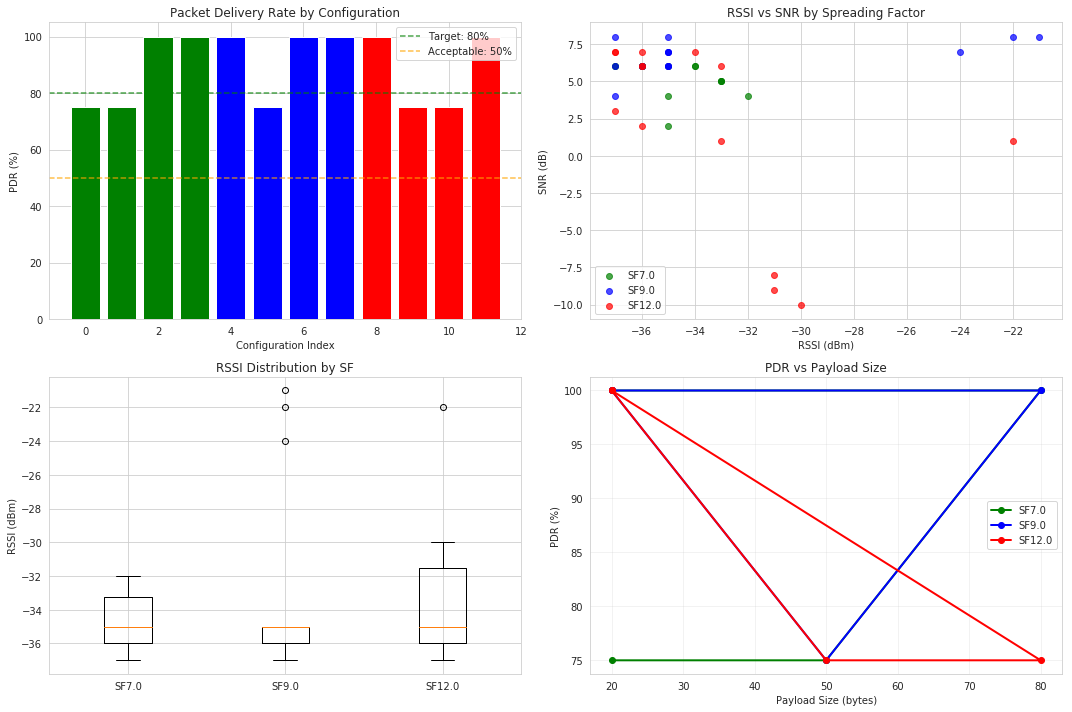

In [9]:
# PDR Analysis Plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# PDR bar chart
ax1.bar(range(len(pdr_stats)), pdr_stats['pdr_percent'], 
        color=['green' if sf==7 else 'blue' if sf==9 else 'red' for sf in pdr_stats['sf']])
ax1.set_title('Packet Delivery Rate by Configuration')
ax1.set_xlabel('Configuration Index')
ax1.set_ylabel('PDR (%)')
ax1.axhline(y=80, color='green', linestyle='--', alpha=0.7, label='Target: 80%')
ax1.axhline(y=50, color='orange', linestyle='--', alpha=0.7, label='Acceptable: 50%')
ax1.legend()

# RSSI vs SNR scatter
colors = {7: 'green', 9: 'blue', 12: 'red'}
for sf in df['sf'].unique():
    sf_data = df[df['sf'] == sf]
    ax2.scatter(sf_data['rssi'], sf_data['snr'], c=colors[sf], 
               label=f'SF{sf}', alpha=0.7)
ax2.set_xlabel('RSSI (dBm)')
ax2.set_ylabel('SNR (dB)')
ax2.set_title('RSSI vs SNR by Spreading Factor')
ax2.legend()

# RSSI distribution
sf_values = sorted(df['sf'].unique())
rssi_data = [df[df['sf'] == sf]['rssi'].values for sf in sf_values]
ax3.boxplot(rssi_data, labels=[f'SF{sf}' for sf in sf_values])
ax3.set_title('RSSI Distribution by SF')
ax3.set_ylabel('RSSI (dBm)')

# PDR vs payload size
for sf in sf_values:
    sf_stats = pdr_stats[pdr_stats['sf'] == sf]
    ax4.plot(sf_stats['len'], sf_stats['pdr_percent'], 
            marker='o', linewidth=2, label=f'SF{sf}', color=colors[sf])
ax4.set_xlabel('Payload Size (bytes)')
ax4.set_ylabel('PDR (%)')
ax4.set_title('PDR vs Payload Size')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot 1 - PDR Bar Chart

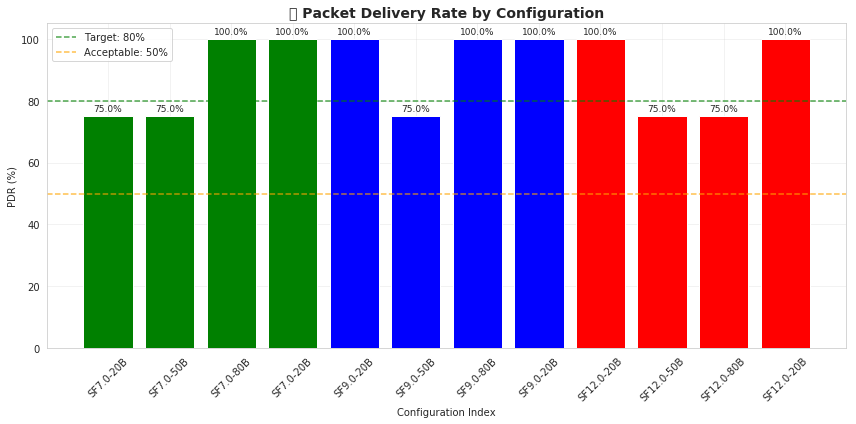

Best PDR: 100.0%
Worst PDR: 75.0%


In [10]:
# Plot 1: Packet Delivery Rate Bar Chart
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

colors = ['green' if sf==7 else 'blue' if sf==9 else 'red' for sf in pdr_stats['sf']]
bars = ax.bar(range(len(pdr_stats)), pdr_stats['pdr_percent'], color=colors)

ax.set_title('📊 Packet Delivery Rate by Configuration', fontsize=14, fontweight='bold')
ax.set_xlabel('Configuration Index')
ax.set_ylabel('PDR (%)')
ax.set_xticks(range(len(pdr_stats)))
ax.set_xticklabels([f"SF{row['sf']}-{row['len']}B" for _, row in pdr_stats.iterrows()], rotation=45)

# Add reference lines
ax.axhline(y=80, color='green', linestyle='--', alpha=0.7, label='Target: 80%')
ax.axhline(y=50, color='orange', linestyle='--', alpha=0.7, label='Acceptable: 50%')

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1, f'{height:.1f}%',
            ha='center', va='bottom', fontsize=9)

ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Best PDR: {pdr_stats['pdr_percent'].max():.1f}%")
print(f"Worst PDR: {pdr_stats['pdr_percent'].min():.1f}%")

# RSSI vs SNR Scatter Plot

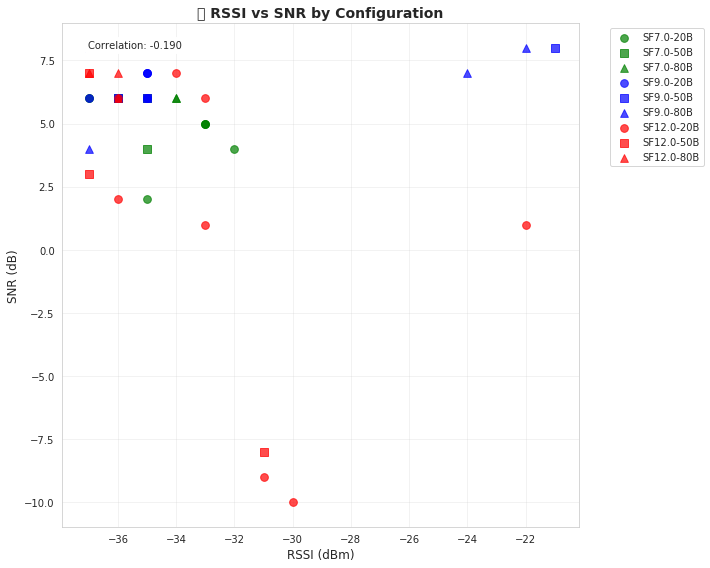

RSSI range: -37.0 to -21.0 dBm
SNR range: -10.0 to 8.0 dB


In [11]:
# Plot 2: RSSI vs SNR Scatter Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

colors = {7: 'green', 9: 'blue', 12: 'red'}
markers = {20: 'o', 50: 's', 80: '^'}  # Different markers for payload sizes

for sf in sorted(df['sf'].unique()):
    for payload in sorted(df['len'].unique()):
        subset = df[(df['sf'] == sf) & (df['len'] == payload)]
        if len(subset) > 0:
            ax.scatter(subset['rssi'], subset['snr'], 
                      c=colors[sf], marker=markers.get(payload, 'o'),
                      label=f'SF{sf}-{payload}B', alpha=0.7, s=60)

ax.set_xlabel('RSSI (dBm)', fontsize=12)
ax.set_ylabel('SNR (dB)', fontsize=12)
ax.set_title('📡 RSSI vs SNR by Configuration', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add correlation info
correlation = df['rssi'].corr(df['snr'])
ax.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
        transform=ax.transAxes, bbox=dict(boxstyle="round,pad=0.3", facecolor="white"))

plt.tight_layout()
plt.show()

print(f"RSSI range: {df['rssi'].min():.1f} to {df['rssi'].max():.1f} dBm")
print(f"SNR range: {df['snr'].min():.1f} to {df['snr'].max():.1f} dB")

# Signal Quality Box Plots

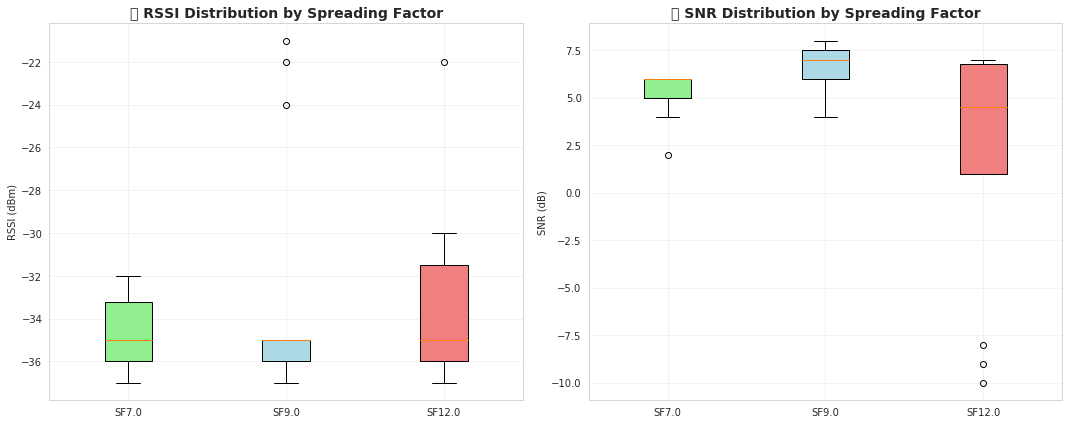

SF7.0: RSSI=-34.7±1.6dBm, SNR=5.2±1.2dB
SF9.0: RSSI=-33.0±5.6dBm, SNR=6.7±1.1dB
SF12.0: RSSI=-33.5±4.1dBm, SNR=1.9±6.3dB


In [12]:
# Plot 3: Signal Quality Distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# RSSI distribution by SF
sf_values = sorted(df['sf'].unique())
rssi_data = [df[df['sf'] == sf]['rssi'].values for sf in sf_values]
box1 = ax1.boxplot(rssi_data, labels=[f'SF{sf}' for sf in sf_values], patch_artist=True)

colors = ['lightgreen', 'lightblue', 'lightcoral']
for patch, color in zip(box1['boxes'], colors):
    patch.set_facecolor(color)

ax1.set_title('📶 RSSI Distribution by Spreading Factor', fontsize=14, fontweight='bold')
ax1.set_ylabel('RSSI (dBm)')
ax1.grid(True, alpha=0.3)

# SNR distribution by SF
snr_data = [df[df['sf'] == sf]['snr'].values for sf in sf_values]
box2 = ax2.boxplot(snr_data, labels=[f'SF{sf}' for sf in sf_values], patch_artist=True)

for patch, color in zip(box2['boxes'], colors):
    patch.set_facecolor(color)

ax2.set_title('📊 SNR Distribution by Spreading Factor', fontsize=14, fontweight='bold')
ax2.set_ylabel('SNR (dB)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
for sf in sf_values:
    sf_data = df[df['sf'] == sf]
    print(f"SF{sf}: RSSI={sf_data['rssi'].mean():.1f}±{sf_data['rssi'].std():.1f}dBm, "
          f"SNR={sf_data['snr'].mean():.1f}±{sf_data['snr'].std():.1f}dB")

# PDR vs Payload Size

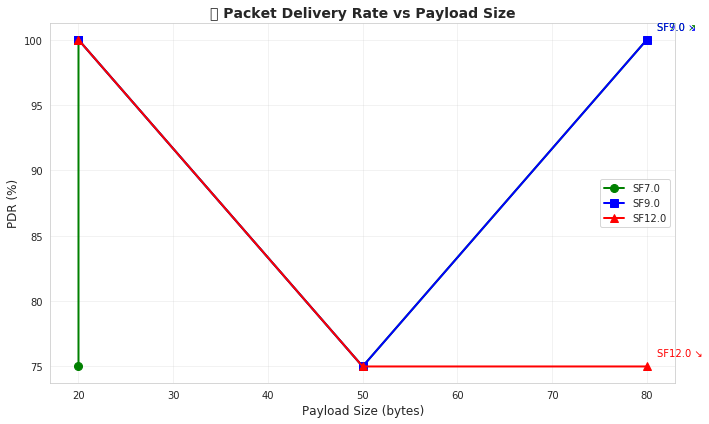

📈 Payload Size Impact Analysis:
SF7.0: PDR range 75.0% - 100.0%
SF9.0: PDR range 75.0% - 100.0%
SF12.0: PDR range 75.0% - 100.0%


In [13]:
# Plot 4: PDR vs Payload Size Analysis
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

colors = {7: 'green', 9: 'blue', 12: 'red'}
markers = ['o', 's', '^']

for i, sf in enumerate(sorted(pdr_stats['sf'].unique())):
    sf_data = pdr_stats[pdr_stats['sf'] == sf].sort_values('len')
    ax.plot(sf_data['len'], sf_data['pdr_percent'], 
            color=colors[sf], marker=markers[i], linewidth=2, markersize=8,
            label=f'SF{sf}')

ax.set_xlabel('Payload Size (bytes)', fontsize=12)
ax.set_ylabel('PDR (%)', fontsize=12)
ax.set_title('📦 Packet Delivery Rate vs Payload Size', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

# Add trend annotations
for sf in sorted(pdr_stats['sf'].unique()):
    sf_data = pdr_stats[pdr_stats['sf'] == sf].sort_values('len')
    if len(sf_data) > 1:
        trend = "↗" if sf_data['pdr_percent'].iloc[-1] > sf_data['pdr_percent'].iloc[0] else "↘"
        ax.annotate(f'SF{sf} {trend}', 
                   xy=(sf_data['len'].iloc[-1], sf_data['pdr_percent'].iloc[-1]),
                   xytext=(10, 10), textcoords='offset points',
                   fontsize=10, color=colors[sf])

plt.tight_layout()
plt.show()

print("📈 Payload Size Impact Analysis:")
for sf in sorted(pdr_stats['sf'].unique()):
    sf_data = pdr_stats[pdr_stats['sf'] == sf]
    print(f"SF{sf}: PDR range {sf_data['pdr_percent'].min():.1f}% - {sf_data['pdr_percent'].max():.1f}%")

# Cell: Boxplot PDR vs SF

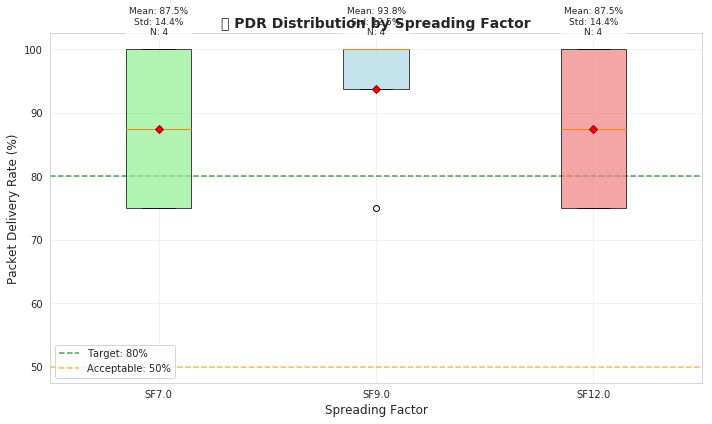

📈 PDR Statistics by Spreading Factor:
----------------------------------------
SF7.0: Mean=87.5%, Median=87.5%, Min=75.0%, Max=100.0%, Std=14.4%
SF9.0: Mean=93.8%, Median=100.0%, Min=75.0%, Max=100.0%, Std=12.5%
SF12.0: Mean=87.5%, Median=87.5%, Min=75.0%, Max=100.0%, Std=14.4%

🔬 ANOVA Test:
F-statistic: 0.273, p-value: 0.767
❌ No significant difference between SF groups (p ≥ 0.05)


In [15]:
# Boxplot: PDR vs Spreading Factor
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Prepare data for boxplot - group PDR values by SF
sf_values = sorted(pdr_stats['sf'].unique())
pdr_by_sf = []

for sf in sf_values:
    sf_data = pdr_stats[pdr_stats['sf'] == sf]['pdr_percent'].values
    pdr_by_sf.append(sf_data)

# Create boxplot
box_plot = ax.boxplot(pdr_by_sf, labels=[f'SF{sf}' for sf in sf_values], 
                      patch_artist=True, showmeans=True)

# Color the boxes
colors = ['lightgreen', 'lightblue', 'lightcoral']
for patch, color in zip(box_plot['boxes'], colors[:len(sf_values)]):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Customize means markers
for mean in box_plot['means']:
    mean.set_marker('D')  # Diamond shape
    mean.set_markerfacecolor('red')
    mean.set_markeredgecolor('darkred')
    mean.set_markersize(6)

ax.set_title('📊 PDR Distribution by Spreading Factor', fontsize=14, fontweight='bold')
ax.set_xlabel('Spreading Factor', fontsize=12)
ax.set_ylabel('Packet Delivery Rate (%)', fontsize=12)

# Add reference lines
ax.axhline(y=80, color='green', linestyle='--', alpha=0.7, label='Target: 80%')
ax.axhline(y=50, color='orange', linestyle='--', alpha=0.7, label='Acceptable: 50%')

# Add grid
ax.grid(True, alpha=0.3)
ax.legend()

# Add statistics annotations
for i, sf in enumerate(sf_values):
    sf_data = pdr_stats[pdr_stats['sf'] == sf]['pdr_percent']
    mean_val = sf_data.mean()
    std_val = sf_data.std()
    
    # Add text box with statistics
    stats_text = f'Mean: {mean_val:.1f}%\nStd: {std_val:.1f}%\nN: {len(sf_data)}'
    ax.text(i+1, max(sf_data) + 2, stats_text, 
            ha='center', va='bottom', fontsize=9,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.tight_layout()
plt.show()

# Print summary statistics
print("📈 PDR Statistics by Spreading Factor:")
print("-" * 40)
for sf in sf_values:
    sf_data = pdr_stats[pdr_stats['sf'] == sf]['pdr_percent']
    print(f"SF{sf}: Mean={sf_data.mean():.1f}%, Median={sf_data.median():.1f}%, "
          f"Min={sf_data.min():.1f}%, Max={sf_data.max():.1f}%, Std={sf_data.std():.1f}%")

# Statistical significance test (if scipy available)
try:
    from scipy import stats
    if len(sf_values) >= 2:
        pdr_groups = [pdr_stats[pdr_stats['sf'] == sf]['pdr_percent'].values for sf in sf_values]
        f_stat, p_value = stats.f_oneway(*pdr_groups)
        print(f"\n🔬 ANOVA Test:")
        print(f"F-statistic: {f_stat:.3f}, p-value: {p_value:.3f}")
        if p_value < 0.05:
            print("✅ Significant difference between SF groups (p < 0.05)")
        else:
            print("❌ No significant difference between SF groups (p ≥ 0.05)")
except ImportError:
    print("\n📊 Install scipy for statistical significance testing")

# RSSI vs SNR Scatter Plot

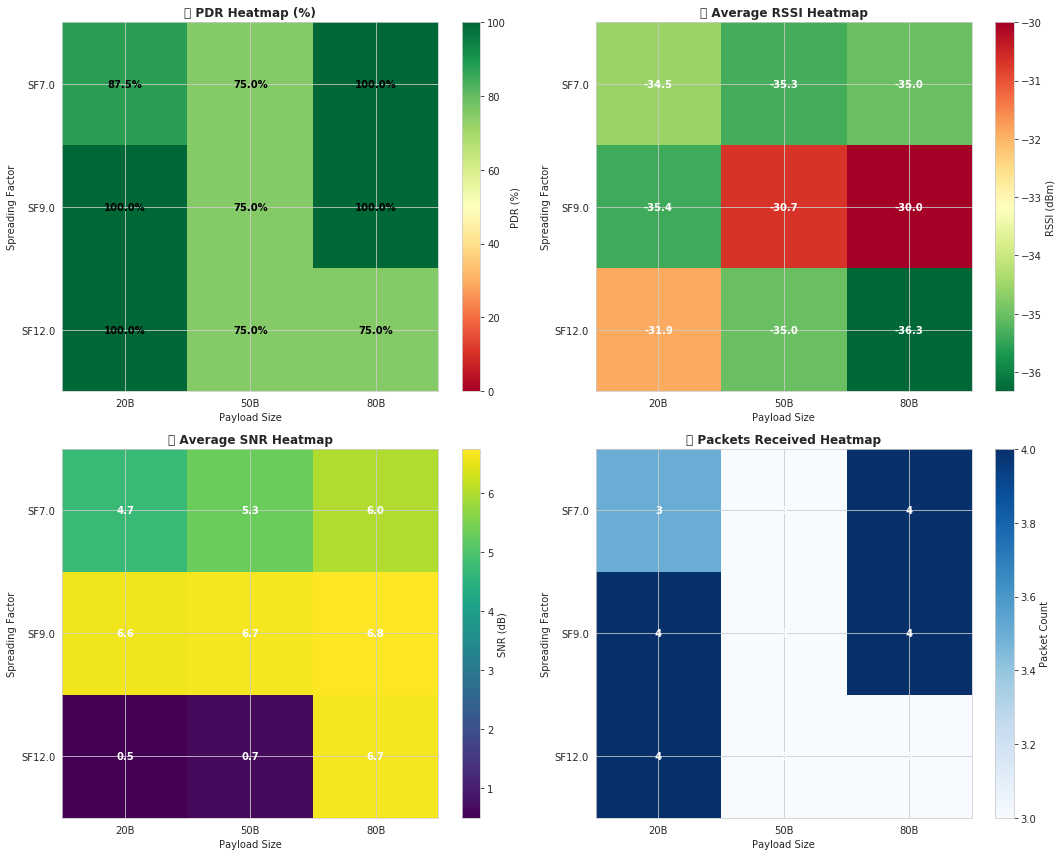

In [16]:
# Plot 5: Performance Heatmaps
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# PDR Heatmap
pdr_pivot = pdr_stats.pivot_table(values='pdr_percent', index='sf', columns='len', fill_value=0)
im1 = ax1.imshow(pdr_pivot.values, cmap='RdYlGn', aspect='auto', vmin=0, vmax=100)
ax1.set_title('✅ PDR Heatmap (%)', fontsize=12, fontweight='bold')
ax1.set_xticks(range(len(pdr_pivot.columns)))
ax1.set_xticklabels([f'{col}B' for col in pdr_pivot.columns])
ax1.set_yticks(range(len(pdr_pivot.index)))
ax1.set_yticklabels([f'SF{idx}' for idx in pdr_pivot.index])
ax1.set_xlabel('Payload Size')
ax1.set_ylabel('Spreading Factor')

# Add text annotations
for i in range(len(pdr_pivot.index)):
    for j in range(len(pdr_pivot.columns)):
        text = ax1.text(j, i, f'{pdr_pivot.values[i, j]:.1f}%',
                       ha="center", va="center", color="black", fontweight='bold')

plt.colorbar(im1, ax=ax1, label='PDR (%)')

# RSSI Heatmap
rssi_pivot = pdr_stats.pivot_table(values='rssi_mean', index='sf', columns='len', fill_value=0)
im2 = ax2.imshow(rssi_pivot.values, cmap='RdYlGn_r', aspect='auto')
ax2.set_title('📡 Average RSSI Heatmap', fontsize=12, fontweight='bold')
ax2.set_xticks(range(len(rssi_pivot.columns)))
ax2.set_xticklabels([f'{col}B' for col in rssi_pivot.columns])
ax2.set_yticks(range(len(rssi_pivot.index)))
ax2.set_yticklabels([f'SF{idx}' for idx in rssi_pivot.index])
ax2.set_xlabel('Payload Size')
ax2.set_ylabel('Spreading Factor')

for i in range(len(rssi_pivot.index)):
    for j in range(len(rssi_pivot.columns)):
        text = ax2.text(j, i, f'{rssi_pivot.values[i, j]:.1f}',
                       ha="center", va="center", color="white", fontweight='bold')

plt.colorbar(im2, ax=ax2, label='RSSI (dBm)')

# SNR Heatmap
snr_pivot = pdr_stats.pivot_table(values='snr_mean', index='sf', columns='len', fill_value=0)
im3 = ax3.imshow(snr_pivot.values, cmap='viridis', aspect='auto')
ax3.set_title('📶 Average SNR Heatmap', fontsize=12, fontweight='bold')
ax3.set_xticks(range(len(snr_pivot.columns)))
ax3.set_xticklabels([f'{col}B' for col in snr_pivot.columns])
ax3.set_yticks(range(len(snr_pivot.index)))
ax3.set_yticklabels([f'SF{idx}' for idx in snr_pivot.index])
ax3.set_xlabel('Payload Size')
ax3.set_ylabel('Spreading Factor')

for i in range(len(snr_pivot.index)):
    for j in range(len(snr_pivot.columns)):
        text = ax3.text(j, i, f'{snr_pivot.values[i, j]:.1f}',
                       ha="center", va="center", color="white", fontweight='bold')

plt.colorbar(im3, ax=ax3, label='SNR (dB)')

# Packet Count Heatmap
count_pivot = pdr_stats.pivot_table(values='packets_received', index='sf', columns='len', fill_value=0)
im4 = ax4.imshow(count_pivot.values, cmap='Blues', aspect='auto')
ax4.set_title('📊 Packets Received Heatmap', fontsize=12, fontweight='bold')
ax4.set_xticks(range(len(count_pivot.columns)))
ax4.set_xticklabels([f'{col}B' for col in count_pivot.columns])
ax4.set_yticks(range(len(count_pivot.index)))
ax4.set_yticklabels([f'SF{idx}' for idx in count_pivot.index])
ax4.set_xlabel('Payload Size')
ax4.set_ylabel('Spreading Factor')

for i in range(len(count_pivot.index)):
    for j in range(len(count_pivot.columns)):
        text = ax4.text(j, i, f'{int(count_pivot.values[i, j])}',
                       ha="center", va="center", color="white", fontweight='bold')

plt.colorbar(im4, ax=ax4, label='Packet Count')

plt.tight_layout()
plt.show()

# Cell 6: Summary Analysis

In [14]:
# Analysis Summary
print("🔬 ANALYSIS RESULTS")
print("=" * 50)

# Best/worst configurations
best_idx = pdr_stats['pdr_percent'].idxmax()
worst_idx = pdr_stats['pdr_percent'].idxmin()

print(f"\n🏆 Best Configuration:")
best = pdr_stats.iloc[best_idx]
print(f"   SF{best['sf']}, BW{best['bw']}, {best['len']}B payload")
print(f"   PDR: {best['pdr_percent']}%, RSSI: {best['rssi_mean']:.1f}dBm")

print(f"\n❌ Worst Configuration:")
worst = pdr_stats.iloc[worst_idx]
print(f"   SF{worst['sf']}, BW{worst['bw']}, {worst['len']}B payload")
print(f"   PDR: {worst['pdr_percent']}%, RSSI: {worst['rssi_mean']:.1f}dBm")

print(f"\n📊 Overall Statistics:")
print(f"   Average PDR: {pdr_stats['pdr_percent'].mean():.1f}%")
print(f"   RSSI range: {df['rssi'].min():.1f} to {df['rssi'].max():.1f} dBm")
print(f"   SNR range: {df['snr'].min():.1f} to {df['snr'].max():.1f} dB")

print(f"\n⏱️ Timing Recommendations:")
for sf in sorted(df['sf'].unique()):
    sf_pdr = pdr_stats[pdr_stats['sf'] == sf]['pdr_percent'].mean()
    if sf_pdr < 50:
        rec = "Increase interval to 15-20s"
    elif sf_pdr < 75:
        rec = "Increase interval to 10-12s"
    else:
        rec = "Current timing acceptable"
    print(f"   SF{sf}: Avg PDR={sf_pdr:.1f}% → {rec}")

🔬 ANALYSIS RESULTS

🏆 Best Configuration:
   SF7.0, BW125.0, 80B payload
   PDR: 100.0%, RSSI: -35.0dBm

❌ Worst Configuration:
   SF7.0, BW125.0, 20B payload
   PDR: 75.0%, RSSI: -36.3dBm

📊 Overall Statistics:
   Average PDR: 89.6%
   RSSI range: -37.0 to -21.0 dBm
   SNR range: -10.0 to 8.0 dB

⏱️ Timing Recommendations:
   SF7.0: Avg PDR=87.5% → Current timing acceptable
   SF9.0: Avg PDR=93.8% → Current timing acceptable
   SF12.0: Avg PDR=87.5% → Current timing acceptable
